# Floquet Dynamics of a Periodically Driven Spin Chain in the Full Hilbert Space

Analabha Roy

For more information about QuTiP see [http://qutip.org](http://qutip.org)

Hamiltonian of the driven Transverse Field Ising model of $N$ spins:
\begin{align*}
 H(t) &= H_0 + \left(h_0 + h\cos{\omega t}\right) H_1\\
H_0 &= -\sum_{i<N} \sigma^x_i \sigma^x_{i+1} - \sigma^x_N\sigma^x_0\\
H_1 &= -\sum_n^N \sigma^z_{n}
\end{align*}
The last term in $H_0$ ensures translational invariance by imposing periodic boundary conditions. By default, let us set $h_0=0$. The Floquet dynamics is contrasted with that of the driven Lipkin-Meshkov-Glick model, whose Hamiltonian involves long-range interactions. The Hamiltonian is
\begin{align*}
 H(t) &= H_0 + \left(h_0 + h\cos{\omega t}\right) H_1\\
H_0 &= \frac{2}{N-1}\sum_{i<j} \sigma^z_i \sigma^z_{j}\\
H_1 &= \sum_n^N \sigma^x_{n}
\end{align*}

Under periodic driving, we look at properties of the $2^N$ Floquet modes at time $t=T$. For each floquet mode at $t=T$, called $|\phi_n\rangle$, where $n\in[0, 2^N-1]$, let us define the *Inverse Participation Ratio* (PR) as
\begin{equation*}
\phi_{IPR}(n) \equiv \sum_m\left\vert\left\langle m\vert \phi_n \right\rangle\right\vert^4
\end{equation*}
Here, $|m\rangle$ is the $m^{th}$ eigenstate of the transverse field, $\sigma_x$ in the Lipkin case, and $\sigma_z$ in the Ising case.

We set a large driving frequency ($\omega = 90$) and investigate two values of drive amplitude $h$. The first is a value of $h$ for which $J_0(\alpha h/\omega)=0$, where $\alpha=2$ for the Ising case and $\alpha=4$ for the Lipkin case. These are contrasted with PR plots far from this resonance. We simulate the exact Floquet dynamics and plot the PRs for both models. 

In [11]:
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve 
from qutip.floquet import floquet_modes

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)


def get_floquet_ising(N, args, **kwargs):

    si = qeye(2)
    
    sx = sigmax()
    sz = sigmaz()

    sx_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H0, H1 = 0.0, 0.0

    # energy splitting terms
    for i in range(N):
        H1 += sz_list[i]

    # interaction terms
    for i in range(N-1):
        H0 += sx_list[i] * sx_list[i+1]
    
    if N > 2:
        H0 += sx_list[-1] * sx_list[0] #Periodic Boundary Conditions
    
    H = [-H0,[-H1,drive]]    
    T = 2 * np.pi/args['omega']

    return floquet_modes(H, T, args, **kwargs)


def get_floquet_zzx(N, args,jmat = None, **kwargs):
    
    if jmat is None:
        jmat = np.diag(np.ones(N),1)

    si = qeye(2)
    
    sx = sigmax()
    sz = sigmaz()

    sx_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H0, H1 = 0.0, 0.0

    # energy splitting terms
    for n in range(N):
        H1 += sx_list[n]

    # interaction terms
    for i in range(N-1):
        for j in range(i+1, N):
            H0 += jmat[i,j] * sz_list[i] * sz_list[j]
            

    H = [H0,[H1,drive]]    
    T = 2 * np.pi/args['omega']

    return floquet_modes(H, T, args, **kwargs)

### The Ising Case:

#### PR plots in the full Hilbert Space

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:28<00:00, 29.59s/it]


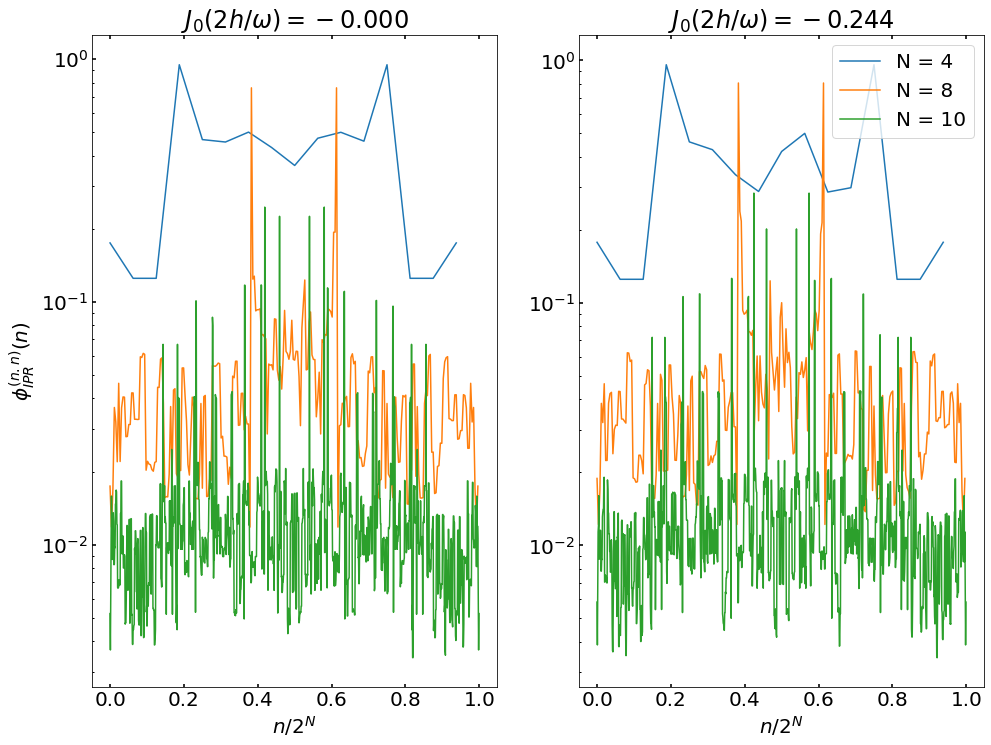

CPU times: user 36min 12s, sys: 35 s, total: 36min 47s
Wall time: 2min 24s


In [12]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
from tqdm import tqdm

plt.rcParams.update({
    "figure.figsize": (16, 12),
    "text.usetex": False,
    "font.size": 20})

freezing_pts = jn_zeros(0, 5)
max_pts = jn_zeros(1,5)

#
# set up the calculation
#

Nvals = [4, 8, 10]            # number of spins
omega = 90.0
w = omega
hfrz = omega * freezing_pts/2
hmax = 1.25 * omega * max_pts/2

def get_iprvals(N, params, **kwargs):
    f_states, f_energies = get_floquet_ising(N, params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

fig, (ax0, ax1) = fig, axs = plt.subplots(1, 2)

h = hfrz[0]
params = {'h0':0.0, 'h':h, 'omega':omega}
ax0.set_title(fr"$J_0(2h/\omega)={j0(2*h/w):1.3f}$")
for N in tqdm(Nvals):
    idxvals = np.arange(2**N)/2**N
    ax0.plot(idxvals, get_iprvals(N, params, sort=True), label=f'N = {N}')

h = hmax[0]
params = {'h0':0.0, 'h':h, 'omega':omega}
ax1.set_title(fr"$J_0(2h/\omega)={j0(2*h/w):1.3f}$")
for N in tqdm(Nvals):
    idxvals = np.arange(2**N)/2**N
    ax1.plot(idxvals, get_iprvals(N, params, sort=True), label=f'N = {N}')
    
for ax in (ax0, ax1):
    ax.set_xlabel(r'$n/2^N$')
    ax.set_yscale("log")

ax0.set_ylabel(r'$\phi^{(n.n)}_{IPR}(n)$')
ax1.legend()
plt.show()

### The Lipkin Case

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:48<00:00, 56.17s/it]


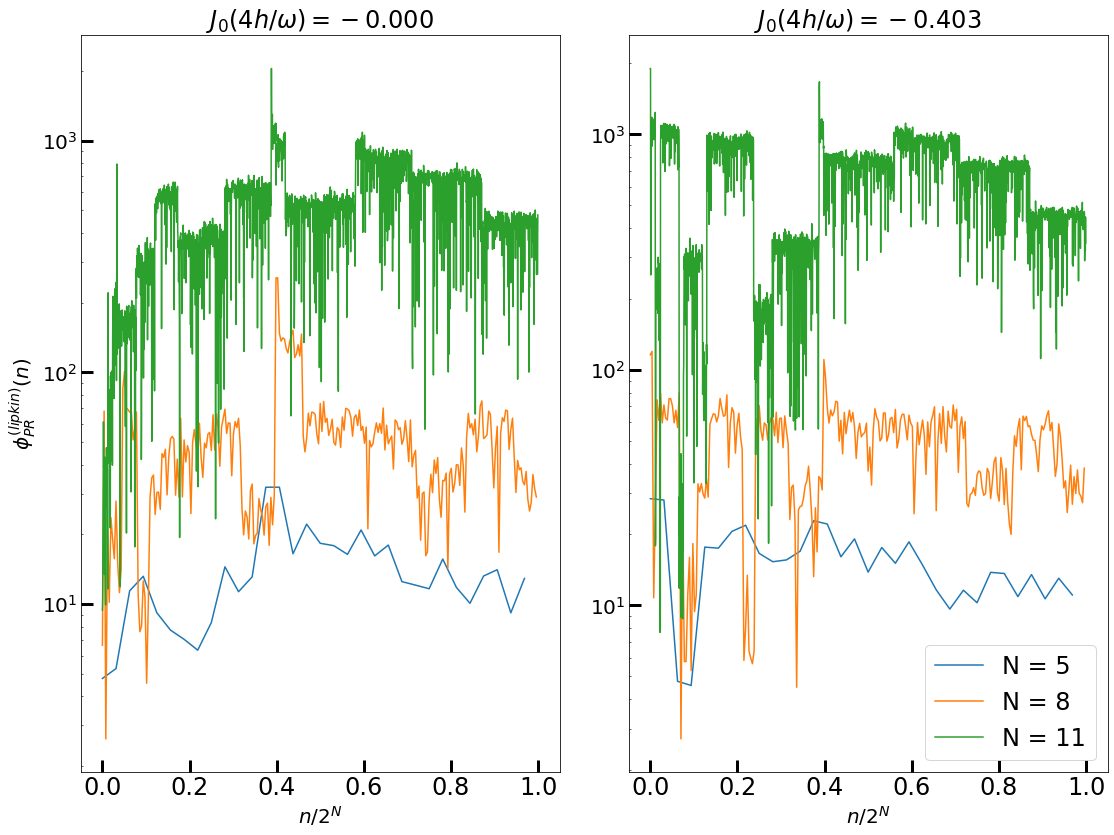

CPU times: user 23min 22s, sys: 50.3 s, total: 24min 12s
Wall time: 4min 47s


In [22]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
from tqdm import tqdm

plt.rcParams.update({
    "figure.figsize": (16, 12),
    "text.usetex": False,
    "font.size": 20})

freezing_pts = jn_zeros(0, 5)
max_pts = jn_zeros(1,5)

#
# set up the calculation
#

Nvals = [5, 8, 11]            # number of spins
omega = 90.0
hfrz = omega * freezing_pts/4
hmax = omega * max_pts/4

def get_iprvals(N, params, **kwargs):
    f_states, f_energies = get_floquet_zzx(N, params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

fig, (ax0, ax1) = fig, axs = plt.subplots(1, 2)

h = hfrz[0]
params = {'h0':0.0, 'h':h, 'omega':omega}
ax0.set_title(fr"$J_0(4h/\omega)={j0(4*h/w):1.3f}$")
for N in tqdm(Nvals):
    idxvals = np.arange(2**N)/2**N
    ax0.plot(idxvals, get_iprvals(N, params, jmat=2.0/(N-1)*np.ones((N,N)), sort=True), label=f'N = {N}')

h = hmax[0]
params = {'h0':0.0, 'h':h, 'omega':omega}
ax1.set_title(fr"$J_0(4h/\omega)={j0(4*h/w):1.3f}$")
for N in tqdm(Nvals):
    idxvals = np.arange(2**N)/2**N
    ax1.plot(idxvals, get_iprvals(N, params, jmat=2.0/(N-1)*np.ones((N,N)), sort=True), label=f'N = {N}')
    
for ax in (ax0, ax1):
    ax.set_xlabel(r'$n/2^N$')
    ax.set_yscale("log")

ax0.set_ylabel(r'$\phi^{(lipkin)}_{IPR}(n)$')
ax1.legend()
plt.show()

### Software version:

In [40]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.6.3
Numpy,1.20.3
SciPy,1.7.3
matplotlib,3.4.3
Cython,0.29.24
Number of CPUs,12
BLAS Info,INTEL MKL
IPython,7.29.0
Python,"3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]"
OS,posix [linux]
